In [23]:
import pandas as pd
import numpy as np
import random
import pickle
import datetime
import seaborn as sns
#import matplotlib as plt
import matplotlib.pyplot as plt

import requests

In [ ]:
import certs

bucket = '<s3-bucket-name>'
model_id = '<dmm-model-id>'
#19-24 06 07

In [ ]:
dmm_api_key = os.environ.get('DMM_API_TOKEN')
daily_data_path = '/mnt/CustomerChurn46/DailyData/'

In [2]:
#Bring in data used to train pickled model that is loaded in later
df = pd.read_csv('/mnt/code/Test&TrainData/ChurnTrainingDataPP.csv')
df.drop('predictionProbability', axis =1,inplace = True)
print(df.shape)
df.head()

(7939, 7)


,custid,dropperc,mins,consecmonths,income,age,churn_Y
0,844336,0.016364,550,28,89.2,45,0
1,146041,0.018349,545,33,54.2,43,0
2,847745,0.018519,378,41,55.3,41,0
3,285565,0.014493,552,32,66.8,31,0
4,754611,0.012132,577,4,87.2,43,0


In [3]:
#append data to istelf to double volume
df2 = df.append(df)

In [4]:
#Reset custid field so that there are no repeats
df2['custid'] = np.random.choice(range(df.custid.min(), df.custid.max()),df2.shape[0], replace=False)

In [5]:
##For each input feature adjust data and round/cast as necessary
#dropperc - 50%-150%
droppJitter = df2.dropperc.apply(lambda x : x*(random.randrange(50,150))/100)
#mins - 70%-130%
minsJitter = df2.mins.apply(lambda x : x*(random.randrange(70,130)/100)).round(0).astype(int)
#consecMonths - 80%-120%
consecMonthsJitter = df2.consecmonths.apply(lambda x : x*(random.randrange(80,120)/100)).round(0).astype(int)
#Income - 40%-160%
incomeJitter = df2.income.apply(lambda x : x*(random.randrange(40,160)/100)).round(1)
#age - 90%-110%
ageJitter = df2.age.apply(lambda x : x*(random.randrange(90,110)/100)).round(0).astype(int)


In [6]:
#Take all the new 'jittered' variables and write to a new df
#Keep original custid and churn_Y fields
df3 = pd.DataFrame({'custid': df2.custid,
       'dropperc': droppJitter, 
       'mins': minsJitter,
       'consecmonths': consecMonthsJitter,
       'income': incomeJitter,
       'age': ageJitter,
       'churn_Y': df2.churn_Y
                   })

In [7]:
df3.head()

,custid,dropperc,mins,consecmonths,income,age,churn_Y
0,452187,0.009000,534,29,122.2,44,0
1,811354,0.026789,561,31,40.7,45,0
2,308904,0.016296,386,38,60.8,38,0
3,348632,0.014058,651,35,50.8,33,0
4,882732,0.007036,617,5,50.6,42,0


In [8]:
#Understand correlations between new jittered data and original
#Should see larger data drift for lower correlations
concatset = pd.concat([df2,df3], axis =1)
concatset.columns=(list(df2.columns)+list('Jittered_'+df3.columns))
print('Correlations between original and altered vars -')
for i,k in enumerate(df2.columns):
    print('{}: {}'.format(k, concatset.corr()[k]['Jittered_'+k].round(4)))


Correlations between original and altered vars -
custid: 1.0
dropperc: 0.7279
mins: 0.7408
consecmonths: 0.9302
income: 0.6112
age: 0.9692
churn_Y: 1.0


In [9]:
#Load in trained model object    
loaded_model = pickle.load(open('/mnt/code/models/ChurnBinaryClassifier.pkl', 'rb'))

/opt/conda/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator AdaBoostClassifier from version 0.22.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:
#Grab between 100 and 500 random rows from jittered data
df_inf = df3.sample(n = random.randint(100,500))
print(df_inf.shape[0], "records selected for sample")
df_inf.head()

126 records selected for sample


,custid,dropperc,mins,consecmonths,income,age,churn_Y
1612,978420,0.027338,438,31,66.1,57,0
1633,542813,0.025607,567,26,90.3,23,0
1034,88544,0.022062,279,23,59.3,41,0
4497,30118,0.029138,406,25,93.6,49,1
3910,5214,0.024834,439,20,181.9,48,0


In [11]:
#Save input features
X = df_inf.loc[:, 'dropperc':'age']
X.head()

,dropperc,mins,consecmonths,income,age
1612,0.027338,438,31,66.1,57
1633,0.025607,567,26,90.3,23
1034,0.022062,279,23,59.3,41
4497,0.029138,406,25,93.6,49
3910,0.024834,439,20,181.9,48


In [12]:
#Get model predictions for the sample of input features defined above
predictions = loaded_model.predict(X)
#Get model prediction probabilities for the sample of input features defined above
probas = loaded_model.predict_proba(X)

/opt/conda/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


In [13]:
df_inf.head()

,custid,dropperc,mins,consecmonths,income,age,churn_Y
1612,978420,0.027338,438,31,66.1,57,0
1633,542813,0.025607,567,26,90.3,23,0
1034,88544,0.022062,279,23,59.3,41,0
4497,30118,0.029138,406,25,93.6,49,1
3910,5214,0.024834,439,20,181.9,48,0


In [14]:
x_df_1= df_inf[['custid','churn_Y']]
x_df_1.head()

,custid,churn_Y
1612,978420,0
1633,542813,0
1034,88544,0
4497,30118,1
3910,5214,0


In [15]:
x_df_2 = x_df_1.rename(columns = {'churn_Y': 'y_gt'})
x_df_2.head()

,custid,y_gt
1612,978420,0
1633,542813,0
1034,88544,0
4497,30118,1
3910,5214,0


In [16]:
#write ground truth data out
churn_groundTruth = pd.DataFrame(df_inf[['custid','churn_Y']]).rename(columns = {'churn_Y': 'y_gt'})
churn_groundTruth.head()

,custid,y_gt
1612,978420,0
1633,542813,0
1034,88544,0
4497,30118,1
3910,5214,0


In [17]:
#Create data set with predictions and pred probabilities
preds_df = pd.DataFrame(data=predictions, columns=['churn_Y'], index=churn_groundTruth.index)
preds_df['predictionProbability']= tuple(probas)

In [18]:
#adjust format of pred probabilities
preds_df['predictionProbability']=preds_df.predictionProbability.apply(lambda x : str(x).replace('(', '[').replace(')', ']'))
preds_df.head()

,churn_Y,predictionProbability
1612,0,[0.51019065 0.48980935]
1633,0,[0.50267696 0.49732304]
1034,0,[0.59697343 0.40302657]
4497,0,[0.50485444 0.49514556]
3910,0,[0.56942116 0.43057884]


In [19]:
df_inf.head()

,custid,dropperc,mins,consecmonths,income,age,churn_Y
1612,978420,0.027338,438,31,66.1,57,0
1633,542813,0.025607,567,26,90.3,23,0
1034,88544,0.022062,279,23,59.3,41,0
4497,30118,0.029138,406,25,93.6,49,1
3910,5214,0.024834,439,20,181.9,48,0


In [20]:
#join prediction and prob data with input features dropping churn_Y
churn_inputs_and_preds = df_inf.drop('churn_Y', axis =1)\
.join(preds_df, how = 'inner').drop_duplicates(subset = 'custid')

In [21]:
#Create 'protected class' feature to monitor for disparity in target distribution
churn_inputs_and_preds['Gender']=np.random.randint(0,3, churn_inputs_and_preds.shape[0])
mymap = {0:'M',1: 'F', 2: 'NB'}
churn_inputs_and_preds['Gender'] = churn_inputs_and_preds['Gender'].apply(lambda x: mymap.get(x))
churn_inputs_and_preds.head()

,custid,dropperc,mins,consecmonths,income,age,churn_Y,predictionProbability,Gender
1612,978420,0.027338,438,31,66.1,57,0,[0.51019065 0.48980935],NB
1633,542813,0.025607,567,26,90.3,23,0,[0.50267696 0.49732304],F
1034,88544,0.022062,279,23,59.3,41,0,[0.59697343 0.40302657],F
4497,30118,0.029138,406,25,93.6,49,0,[0.50485444 0.49514556],M
3910,5214,0.024834,439,20,181.9,48,0,[0.56942116 0.43057884],M


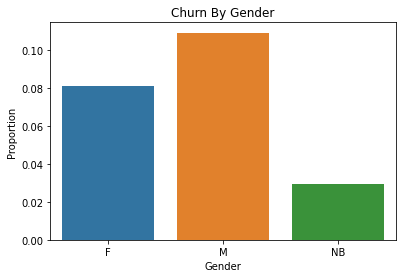

In [25]:
#Add visualization of protected class for tracking purposes
ax = sns.barplot(x = ['F', 'M', 'NB'], y = churn_inputs_and_preds.groupby('Gender').mean()['churn_Y'])

ax.set_title('Churn By Gender')
ax.set_ylabel('Proportion')
ax.set_xlabel('Gender')
fig = ax.get_figure()
fig.set_size_inches(12,4)
plt.gcf().subplots_adjust(left=0.5)

fig.savefig('/mnt/code/Viz/protected_class_monitoring.png')

In [26]:
## Run two checks below to validate input and GT data is of same size and contains same custIDs

lenCheck = churn_inputs_and_preds.shape[0]==churn_groundTruth.shape[0]
print('Length Check Pass:', lenCheck)

idCheck= (churn_inputs_and_preds.custid.sort_values()==churn_groundTruth.custid.sort_values())\
.sum() ==churn_inputs_and_preds.shape[0]
print('ID Check Pass:', idCheck)

Length Check Pass: True
ID Check Pass: True


In [27]:
#Write input and pred data to DailyData folder # ---> this is the ground truth
#daily_data_path = '/mnt/CustomerChurn46/DailyData/'

#daily_data_path = '/mnt/CustomerChurn46/DailyData/'
daily_data_path = '/mnt/data/DMM-classification/DailyData/'


input_and_pred_path = str(daily_data_path+'inputs_and_preds_'+str(datetime.date.today())+'.csv')
churn_inputs_and_preds.to_csv(input_and_pred_path, index = False)

In [28]:
#Write GT data to DailyData folder
ground_truth_path = str(daily_data_path+'ground_truth_'+str(datetime.date.today())+'.csv')
churn_groundTruth.to_csv(ground_truth_path, index = False)

In [29]:
#Upload input&pred data and GT data to s3 bucket 
upload_to_s3.upload(input_and_pred_path, bucket)
upload_to_s3.upload(ground_truth_path, bucket)

NameError: name 'upload_to_s3' is not defined

## At this point we are done with s3

In [50]:
#Define file names for payload construction below
inputs_file_name = str('inputs_and_preds_'+str(datetime.date.today())+'.csv')
ground_truth_file_name = str('ground_truth_'+str(datetime.date.today())+'.csv')

In [51]:
inputs_file_name

'inputs_and_preds_2022-05-04.csv'

In [52]:
#Create inputs and prediction data payload
inputs_payload = """
{{
"datasetDetails": {{
        "name": "{0}",
        "datasetType": "file",
        "datasetConfig": {{
            "path": "{0}",
            "fileFormat": "csv"
        }},
        "datasourceName": "churn-dmm-46",
        "datasourceType": "s3"
    }}
}}
""".format(inputs_file_name)

In [53]:
#Define api endpoint # Adding dmm model ID
inputs_url = "https://demo.dominodatalab.com/model-monitor/v2/api/model/{}/register-dataset/prediction".format(model_id)

NameError: name 'model_id' is not defined

In [55]:
#Set up call headers  # Adding dmm_api_key
headers = {
           'X-DMM-API-KEY': dmm_api_key,
           'Content-Type': 'application/json'
          }

NameError: name 'dmm_api_key' is not defined

In [57]:
#Make API call # importing requests
inputs_response = requests.request("PUT", inputs_url, headers=headers, data = inputs_payload)

NameError: name 'requests' is not defined

In [58]:
#create GT payload    
ground_truth_payload = """
{{

"datasetDetails": {{
        "name": "{0}",
        "datasetType": "file",
        "datasetConfig": {{
            "path": "{0}",
            "fileFormat": "csv"
        }},
        "datasourceName": "churn-dmm-46",
        "datasourceType": "s3"
    }}
}}
""".format(ground_truth_file_name)

In [59]:
#Define api endpoint
ground_truth_url = "https://demo.dominodatalab.com/model-monitor/v2/api/model/{}/register-dataset/ground_truth".format(model_id)

NameError: name 'model_id' is not defined

In [60]:
#Make api call
ground_truth_response = requests.request("PUT", ground_truth_url, headers=headers, data = ground_truth_payload)

NameError: name 'requests' is not defined

In [61]:
#Print response
print(ground_truth_response.text.encode('utf8'))

NameError: name 'ground_truth_response' is not defined